In [1]:
import numpy as np
import random
# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

In [ ]:
import pandas as pd
#Loading the data from a csv file
reviews = pd.read_csv("https://raw.githubusercontent.com/kbrennig/MODS_WS25_26/refs/heads/main/data/imdb_sample.csv")

In [3]:
# Recode sentiment_human
reviews['sentiment_positive'] = np.where(reviews['sentiment_human'] == 'positive', 1, 0)


In [4]:
# Preprocessing
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download the punkt resource
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Define function with all necessary preprocessing steps for our IMDB reviews. In comparison to last week we now use Lemmatization instead of Stemming.
def preprocess(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # create lemmatizer object
    lemmatizer = WordNetLemmatizer()

    # lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # get list of stopwords in English
    stopwords = nltk.corpus.stopwords.words("english")

    # remove stopwords
    filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stopwords]

    # remove punctuation
    filtered_tokens_nopunct = [token for token in filtered_tokens if token not in string.punctuation]

    return  " ".join(filtered_tokens_nopunct)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Apply text preprocessing
reviews['processed_text'] = reviews['text'].apply(preprocess)
reviews['processed_text'].iloc[0]  # Display first processed review

"stuff going moment MJ 've started listening music watching odd documentary watched Wiz watched Moonwalker Maybe want get certain insight guy thought wa really cool eighty maybe make mind whether guilty innocent Moonwalker part biography part feature film remember going see cinema wa originally released ha subtle message MJ 's feeling towards press also obvious message drug bad m'kay. br br Visually impressive course Michael Jackson unless remotely like MJ anyway going hate find boring may call MJ egotist consenting making movie MJ fan would say made fan true really nice him. br br actual feature film bit finally start 20 minute excluding Smooth Criminal sequence Joe Pesci convincing psychopathic powerful drug lord want MJ dead bad beyond MJ overheard plan Nah Joe Pesci 's character ranted wanted people know supplying drug etc dunno maybe hate MJ 's music. br br Lots cool thing like MJ turning car robot whole Speed Demon sequence Also director must patience saint came filming kiddy Bad

In [6]:
# Remove additional irrelevant words (amp, document)
reviews['processed_text'] = reviews['processed_text'].replace(['amp', 'document'], '', regex=True)
reviews['processed_text'].iloc[0]


"stuff going moment MJ 've started listening music watching odd ary watched Wiz watched Moonwalker Maybe want get certain insight guy thought wa really cool eighty maybe make mind whether guilty innocent Moonwalker part biography part feature film remember going see cinema wa originally released ha subtle message MJ 's feeling towards press also obvious message drug bad m'kay. br br Visually impressive course Michael Jackson unless remotely like MJ anyway going hate find boring may call MJ egotist consenting making movie MJ fan would say made fan true really nice him. br br actual feature film bit finally start 20 minute excluding Smooth Criminal sequence Joe Pesci convincing psychopathic powerful drug lord want MJ dead bad beyond MJ overheard plan Nah Joe Pesci 's character ranted wanted people know supplying drug etc dunno maybe hate MJ 's music. br br Lots cool thing like MJ turning car robot whole Speed Demon sequence Also director must patience saint came filming kiddy Bad sequenc

In [7]:
from sklearn.model_selection import train_test_split

reviews_preprocessed = reviews.drop(columns="text")

X = reviews_preprocessed.drop(columns=['sentiment_positive'])
y = reviews_preprocessed['sentiment_positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(min_df=50)
tfidf_vectorizer = vectorizer.fit(X_train['processed_text'])
reviews_matrix_train_tfidf = tfidf_vectorizer.transform(X_train['processed_text'])
reviews_matrix_test_tfidf = tfidf_vectorizer.transform(X_test['processed_text'])


reviews_matrix_train_df_tfidf = pd.DataFrame(reviews_matrix_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
reviews_matrix_test_df_tfidf = pd.DataFrame(reviews_matrix_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())



In [10]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf_01 = RandomForestClassifier(random_state=42).fit(reviews_matrix_train_df_tfidf, y_train)


Accuracy (Random Forests): 0.828


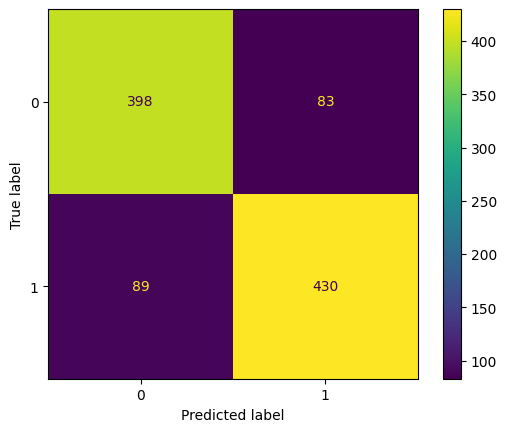

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

predictions_testset_rf01 = rf_01.predict_proba(reviews_matrix_test_df_tfidf)[:, 1]
predictions_testset_rf01_binary = np.where(predictions_testset_rf01 > 0.5, 1, 0)

# Calculate Accuracy

accuracy_rf = accuracy_score(y_test, predictions_testset_rf01_binary)
print("Accuracy (Random Forests):", accuracy_rf)

# Create the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_testset_rf01_binary)

AUC Score: 0.9015077772303206


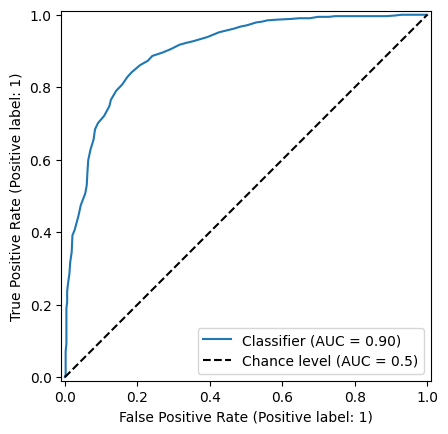

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_testset_rf01)
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_testset_rf01, plot_chance_level=True)